In [1]:
import pandas as pd
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 21.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=e5c4483bde4a6ea28ac0136a9907037e00e49f1f2c0c73b3f5e7817002535453
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=cc8ec60df2ed32114e48584c4b47870a3a4c9e780f1e28ece429f6bb4e97a173
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [0]:
df1=pd.read_excel('/content/ShiladithData_March182020.xlsx')
df2=pd.read_excel('/content/SkartikData_March182020.xlsx')

In [6]:
df2.head(1)

,Unnamed: 0,Contact,Top Skills,Languages,Certifications,Honors-Awards,Publications,Summary,Experience,Education,Designation_1,ExpDurationInMonths_1,Experience_Summary_1,Designation_2,ExpDurationInMonths_2,Experience_Summary_2,Education_1,EduDurationInMonths_1,Education_2,EduDurationInMonths_2,URL
0,0,"['www.linkedin.com/in/srihari-j\n(LinkedIn)', ...","['Machine Learning', 'Deep Learning', 'Angular...",NaN,"['Sequence Models', 'Convolutional Neural Netw...","['Wackiest Idea Award', 'Winner - Programming ...",NaN,"['A versatile, self-driven and passionate indi...","['Arizona State University', '5 months', 'Teac...","['Arizona State University', 'Master of Scienc...",Teaching Assistant,5.0,['Teaching Assistant for CSE205 - Object-Orien...,Research Assistant,4.0,['Developing automated memory allocation and p...,"Master of Science - MS,Computer Science·(2019-...",24.0,"Bachelor of Technology,Information Technology·...",48.0,www.linkedin.com/in/srihari-j


In [7]:
df1.shape

(374, 21)

In [8]:
df2.shape

(390, 21)

In [0]:
df_final = pd.concat([df1, df2],ignore_index=True)

In [10]:
df_final.shape

(764, 21)

In [11]:
len(df_final['URL'])

764

In [0]:
df_dup = df_final.drop_duplicates('URL', keep='last')

In [13]:
df_dup.shape

(748, 21)

In [14]:
!python3 -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [15]:
df_dup.columns

Index(['Unnamed: 0', 'Contact', 'Top Skills', 'Languages', 'Certifications',
       'Honors-Awards', 'Publications', 'Summary', 'Experience', 'Education',
       'Designation_1', 'ExpDurationInMonths_1', 'Experience_Summary_1',
       'Designation_2', 'ExpDurationInMonths_2', 'Experience_Summary_2',
       'Education_1', 'EduDurationInMonths_1', 'Education_2',
       'EduDurationInMonths_2', 'URL'],
      dtype='object')

In [0]:
#del df_dup['test']

In [18]:
df_dup.columns

Index(['Unnamed: 0', 'Contact', 'Top Skills', 'Languages', 'Certifications',
       'Honors-Awards', 'Publications', 'Summary', 'Experience', 'Education',
       'Designation_1', 'ExpDurationInMonths_1', 'Experience_Summary_1',
       'Designation_2', 'ExpDurationInMonths_2', 'Experience_Summary_2',
       'Education_1', 'EduDurationInMonths_1', 'Education_2',
       'EduDurationInMonths_2', 'URL'],
      dtype='object')

In [0]:
df2 = df_dup.assign(ColumnA = df_dup["Summary"].astype(str) + ', ' + \
  df_dup["Experience_Summary_1"].astype(str) + ', ' +df_dup['Experience_Summary_2'].astype(str))

In [20]:
df2['ColumnA'][1]

"['Top Skills', 'Entrepreneurship', 'Seed Capital', 'Trading', 'Languages', 'English', 'Vivek is extremely passionate about financial markets and educating\\npeople on various aspects of finance, necessary for inclusive\\ndevelopment in society. ', 'He started his career as analyst and went on to build one of the\\nlargest financial market trading firms in India. He loves technology\\nand uses the same to its full potential in building his business\\nenterprises. Currently he is full time involved in elearnmarkets.com\\nand stockedge which are truly revolutionizing the way financial\\nmarket is approached in India, particularly by youngsters. '], ['Empowering the individual retail investors, particularly first-timers like', 'millennials with right learning, accurate data and effective analytics for', 'independent financial decisions.', 'Over 1 million downloads and active user base of 200,000 with a rating of 4.7', '(highest rated finance app in India, in this category) speaks a lot ab

In [0]:
data = df2.ColumnA.values
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

In [0]:
def b(text):
    for ch in ['\\n','.',"\'",'\\s','[]','[]','[',']','-','"','=>',':','\\uf','=','(',')','\\xa0','•','&','.',',',"'"]:
        if ch in text:
            text = text.replace(ch," ")
    return text

In [0]:
data = [b(sent) for sent in data]

In [43]:
type(data)

list

# **Tokenize words and Clean-up text**

In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [0]:
data_orig = list(sent_to_words(data))

In [127]:
data_orig[:1]

[['nan', 'keventer', 'agro', 'nan']]

In [128]:
len(data_orig)

748

In [0]:
data_words=data_orig

In [0]:
i=0
while i < len(data_words):
    try:
      data_words[i].remove('nan')
    except:
      i+=1
      continue
    i+=1

In [134]:
data_words[:1]

[['keventer', 'agro']]

In [135]:
len(test)

748

# **Creating Bigram and Trigram Models**

In [136]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['top', 'skills', 'seed', 'capital', 'trading', 'languages_english', 'vivek', 'is', 'extremely', 'passionate_about', 'financial', 'markets', 'and', 'educating', 'people', 'on', 'various', 'aspects', 'of', 'finance', 'necessary', 'for', 'inclusive', 'development', 'in', 'society', 'he', 'started', 'his', 'career', 'as', 'analyst', 'and', 'went', 'on', 'to', 'build', 'one', 'of', 'the', 'largest', 'financial', 'market', 'trading', 'firms', 'in', 'india', 'he', 'loves', 'technology', 'and', 'uses', 'the', 'same', 'to', 'its', 'full', 'potential', 'in', 'building', 'his', 'business', 'enterprises', 'currently', 'he', 'is', 'full', 'time', 'involved', 'in', 'elearnmarkets', 'com', 'and', 'stockedge', 'which', 'are', 'truly', 'revolutionizing', 'the', 'way', 'financial', 'market', 'is', 'approached', 'in', 'india', 'particularly', 'by', 'youngsters', 'empowering', 'the', 'individual', 'retail', 'investors', 'particularly', 'first', 'timers', 'like', 'millennials', 'with', 'right', 'learning'

# **Remove Stopwords, Make Bigrams and Lemmatize**

In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# **Call functions in order**

In [150]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_orig = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized_orig[:2])

[[], ['top', 'skill', 'seed', 'capital', 'trading', 'extremely', 'passionate', 'financial', 'market', 'educate', 'people', 'various', 'aspect', 'finance', 'necessary', 'society', 'start', 'career', 'analyst', 'go', 'build', 'large', 'financial', 'market', 'trading', 'firm', 'love', 'technology', 'use', 'full', 'potential', 'building', 'business', 'enterprise', 'currently', 'full', 'time', 'involve', 'elearnmarket', 'com', 'truly', 'revolutionize', 'way', 'financial', 'market', 'approach', 'particularly', 'youngster', 'empower', 'individual', 'retail', 'investor', 'particularly', 'first', 'timer', 'millennial', 'right', 'learn', 'accurate', 'datum', 'effective', 'analytic', 'independent', 'financial', 'decision', 'download', 'active', 'user', 'base', 'rate', 'high', 'rate', 'finance', 'category', 'speak', 'effort', 'elearnmarket', 'founder', 'elearnmarket', 'com', 'dedicate', 'elearne', 'market', 'place', 'orient', 'course', 'industry', 'expert', 'collaboration', 'industry', 'leader', '

In [0]:
data_lemmatized=[x for x in data_lemmatized_orig if x]

# **Create the Dictionary and Corpus needed for Topic Modeling**

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them

In [154]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 4), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 4), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 2), (84, 1), (85, 1), (86, 2), (87, 1), (88, 1), (89, 1)]]


In [158]:
id2word[83]

'trading'

In [159]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accurate', 1),
  ('active', 1),
  ('analyst', 1),
  ('analytic', 1),
  ('approach', 1),
  ('aspect', 1),
  ('base', 1),
  ('build', 1),
  ('building', 1),
  ('business', 1),
  ('capital', 1),
  ('career', 1),
  ('category', 1),
  ('collaboration', 1),
  ('com', 3),
  ('course', 1),
  ('currently', 2),
  ('datum', 1),
  ('decision', 1),
  ('dedicate', 1),
  ('direct', 1),
  ('download', 1),
  ('educate', 1),
  ('effective', 1),
  ('effort', 1),
  ('elearne', 1),
  ('elearnmarket', 3),
  ('empower', 1),
  ('enterprise', 1),
  ('expert', 1),
  ('extremely', 1),
  ('finance', 2),
  ('financial', 4),
  ('fincubation', 1),
  ('firm', 1),
  ('first', 1),
  ('founder', 1),
  ('full', 2),
  ('go', 1),
  ('high', 1),
  ('icici', 1),
  ('independent', 1),
  ('individual', 1),
  ('industry', 2),
  ('interactive', 1),
  ('investor', 1),
  ('involve', 1),
  ('joint', 1),
  ('large', 1),
  ('leader', 1),
  ('learn', 1),
  ('learning', 1),
  ('lot', 1),
  ('love', 1),
  ('market', 4),
  ('millenni

# **Building the Topic Model**

In [0]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# **View the topics in LDA model**

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [161]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.037*"resume" + 0.029*"human" + 0.025*"receive" + 0.020*"serve" + '
  '0.018*"single" + 0.017*"lab" + 0.013*"chief" + 0.012*"mobility" + '
  '0.011*"cell" + 0.011*"experiment"'),
 (1,
  '0.040*"business" + 0.030*"management" + 0.026*"experience" + 0.020*"team" + '
  '0.017*"client" + 0.016*"year" + 0.016*"service" + 0.016*"manage" + '
  '0.012*"strategy" + 0.011*"work"'),
 (2,
  '0.028*"base" + 0.022*"com" + 0.020*"child" + 0.019*"early" + '
  '0.018*"technology" + 0.015*"learn" + 0.014*"science" + 0.014*"assessment" + '
  '0.014*"interest" + 0.014*"http"'),
 (3,
  '0.019*"recruitment" + 0.016*"design" + 0.015*"requirement" + '
  '0.014*"different" + 0.014*"project" + 0.014*"work" + 0.014*"candidate" + '
  '0.013*"team" + 0.013*"page" + 0.013*"time"'),
 (4,
  '0.036*"work" + 0.021*"also" + 0.019*"policy" + 0.019*"role" + '
  '0.018*"various" + 0.017*"government" + 0.016*"international" + '
  '0.016*"include" + 0.014*"member" + 0.013*"part"'),
 (5,
  '0.067*"technology" + 0.033

Topic 0 is represented as 
(0,
  '0.037*"resume" + 0.029*"human" + 0.025*"receive" + 0.020*"serve" + '
  '0.018*"single" + 0.017*"lab" + 0.013*"chief" + 0.012*"mobility" + '
  '0.011*"cell" + 0.011*"experiment"'),
It means the top 10 keywords that contribute to this topic are: resume,human etc and the weight of resume on Topic 0 is 0.037
The weights reflect how important a keyword is to that topic.
Looking at these keywords, we need to guess what this topic could be.
Likewise we you go through the remaining topic keywords and judge what the topic is

# **Compute Model Perplexity and Coherence Score**

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is.

In [162]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
#We have got a low coherence score. 
#We can try to adjust your parameters alpha = .1, beta = .01 or .001, seed = 123 or get better data


Perplexity:  -7.652943371086192

Coherence Score:  0.3947378205683595


# **Visualize the topics-keywords**

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords

In [163]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.294811  0.030751       1        1  25.394558
3      0.228646 -0.089217       2        1  11.791391
10     0.144021  0.175140       3        1   8.855008
6      0.175143 -0.202200       4        1   6.788202
4      0.073975  0.095393       5        1   6.432961
12     0.153390  0.072554       6        1   6.221451
7      0.050095  0.181694       7        1   4.627520
17    -0.040203 -0.105501       8        1   3.843676
13     0.031276 -0.234169       9        1   3.819776
11    -0.047763  0.070521      10        1   2.773047
2     -0.049058 -0.011566      11        1   2.614376
5     -0.042355 -0.030972      12        1   2.533395
18    -0.147316 -0.054445      13        1   2.273535
14    -0.078779  0.090376      14        1   2.233558
16    -0.134946 -0.013689      15        1   1.936957
8     -0.117804 -0.075339      16        1   1.887772
15    -0.040144  0.018190      17        1   1.879537
9     -0.136308  0.045469      18        1   1.827064
0     -0.147087  0.017259      19        1   1.483748
19    -0.169593  0.019752      20        1   0.782471, topic_info=     Category        Freq           Term       Total  loglift  logprob
17    Default  356.000000          datum  356.000000  30.0000  30.0000
178   Default  516.000000     management  516.000000  29.0000  29.0000
78    Default  343.000000     technology  343.000000  28.0000  28.0000
337   Default  337.000000        project  337.000000  27.0000  27.0000
433   Default  190.000000           sale  190.000000  26.0000  26.0000
...       ...         ...            ...         ...      ...      ...
1577  Topic20    2.667719     wide_range    5.884917   4.0593  -5.0006
421   Topic20    3.193082  profitability    9.326271   3.7786  -4.8208
2315  Topic20    3.060605           self   11.870920   3.4950  -4.8632
4216  Topic20    2.528496           cold    8.483460   3.6400  -5.0542
774   Topic20    2.729016    sustainable   23.481607   2.6982  -4.9779

[1062 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
563       1  0.981592      ability
1383      5  0.910065     academic
1383      8  0.079136     academic
2617      3  0.941124   accelerate
626      14  0.580279  achievement
...     ...       ...          ...
253       9  0.020074         year
253      12  0.008603         year
253      16  0.002868         year
1127     12  0.963569  years_month
3911     19  0.757067          yet

[1671 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 11, 7, 5, 13, 8, 18, 14, 12, 3, 6, 19, 15, 17, 9, 16, 10, 1, 20])

# **Interpretation of this chart:**

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.
A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.
A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.
If you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. 
These words are the salient keywords that form the selected topic.
So far we have built a model by using 20 as the number of natural topics in the document.
Now we will improve upon this model by using Mallet’s version of LDA algorithm and 
then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

# **Building LDA Mallet Model**

Mallet’s version, however, often gives a better quality of topics.
Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

In [164]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2020-03-19 14:46:03--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  17.2MB/s    in 0.9s    

2020-03-19 14:46:04 (17.2 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [0]:
!unzip /content/mallet-2.0.8.zip

In [0]:
#/content/mallet-2.0.8/bin/mallet

In [173]:
!pwd

/content


In [175]:
mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [176]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(5,
  [('program', 0.06776003452740613),
   ('training', 0.029779887785930083),
   ('development', 0.02762192490289167),
   ('support', 0.022442813983599482),
   ('service', 0.020716443677168753),
   ('impact', 0.01985325852395339),
   ('develop', 0.017695295640914977),
   ('human', 0.01640051791109193),
   ('community', 0.015105740181268883),
   ('include', 0.0146741476046612)]),
 (10,
  [('team', 0.08649062380405664),
   ('provide', 0.03673938002296211),
   ('drive', 0.03176425564485266),
   ('performance', 0.024492920015308076),
   ('process', 0.022196708763872943),
   ('set', 0.02104860313815538),
   ('page', 0.02066590126291619),
   ('service', 0.020283199387677),
   ('ensure', 0.019135093761959432),
   ('support', 0.018752391886720246)]),
 (15,
  [('industry', 0.04858757062146893),
   ('client', 0.045574387947269306),
   ('solution', 0.03465160075329567),
   ('leadership', 0.03389830508474576),
   ('business', 0.03352165725047081),
   ('deliver', 0.026365348399246705),
   ('orga

By changing the LDA algorithm, we increased the coherence score from 0.3 to 0.4

# **How to find the optimal number of topics for LDA?**

Build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value

The compute_coherence_values() function trains multiple LDA models and provides the models and their corresponding coherence scores.

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

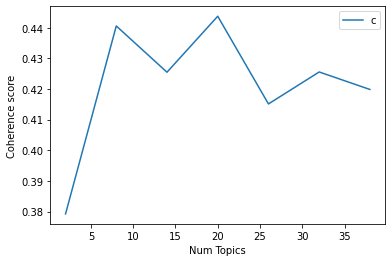

In [180]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [181]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3792
Num Topics = 8  has Coherence Value of 0.4406
Num Topics = 14  has Coherence Value of 0.4255
Num Topics = 20  has Coherence Value of 0.4437
Num Topics = 26  has Coherence Value of 0.4151
Num Topics = 32  has Coherence Value of 0.4255
Num Topics = 38  has Coherence Value of 0.4198


In [182]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.054*"project" + 0.044*"work" + 0.029*"experience" + 0.023*"design" + '
  '0.018*"development" + 0.017*"software" + 0.014*"system" + 0.014*"test" + '
  '0.014*"involve" + 0.013*"team"'),
 (1,
  '0.031*"client" + 0.024*"management" + 0.018*"process" + 0.017*"end" + '
  '0.017*"professional" + 0.016*"level" + 0.014*"handle" + 0.013*"source" + '
  '0.013*"page" + 0.013*"team"'),
 (2,
  '0.048*"research" + 0.041*"technology" + 0.022*"student" + 0.018*"work" + '
  '0.018*"design" + 0.017*"engineering" + 0.015*"experienced" + 0.014*"strong" '
  '+ 0.014*"system" + 0.012*"interest"'),
 (3,
  '0.039*"business" + 0.035*"lead" + 0.026*"service" + 0.020*"team" + '
  '0.019*"corporate" + 0.019*"strategy" + 0.018*"industry" + '
  '0.017*"leadership" + 0.016*"global" + 0.016*"people"'),
 (4,
  '0.063*"datum" + 0.027*"analytic" + 0.025*"model" + 0.023*"skill" + '
  '0.021*"science" + 0.018*"experience" + 0.017*"domain" + 0.016*"customer" + '
  '0.016*"solution" + 0.015*"data"'),
 (5,
  '0.05

# **Finding the dominant topic in each sentence**

In [183]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.2334,"year, company, financial, experience, work, bu...",nan Keventer Agro nan
1,1,6.0,0.1467,"management, business, marketing, product, sale...",Top Skills Entrepreneurship Seed Capit...
2,2,3.0,0.3918,"business, lead, service, team, corporate, stra...",nan Responsible for managing Hughes Systiqu...
3,3,1.0,0.1437,"client, management, process, end, professional...",Yashwant Mahadik Yash a seasoned global HR...
4,4,7.0,0.2461,"work, learn, base, include, government, world,...",RESUME Techdata Solutions India
5,5,6.0,0.4157,"management, business, marketing, product, sale...",Top Skills Business Development Start ...
6,6,6.0,0.2710,"management, business, marketing, product, sale...",A senior professional holding P L accountabi...
7,7,4.0,0.1593,"datum, analytic, model, skill, science, experi...",An award winning Marketing Professional Poo...
8,8,7.0,0.1541,"work, learn, base, include, government, world,...",Top Skills JavaScript AJAX Algorith...
9,9,6.0,0.3185,"management, business, marketing, product, sale...",A school dropout to an IIM graduate my teme...


# **Find the most representative document for each topic**

In [187]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7680,"project, work, experience, design, development...",nan NoBroker com is world s largest C2C rea...
1,1.0,0.7596,"client, management, process, end, professional...",A designer and marketer who looks for the in...
2,2.0,0.5910,"research, technology, student, work, design, e...",I am a highly accomplished Technical leader ...
3,3.0,0.5860,"business, lead, service, team, corporate, stra...",A seasoned leader in Corporate Strategy and ...
4,4.0,0.4872,"datum, analytic, model, skill, science, experi...",nan Aviation Services East Africa The ...
5,5.0,0.4967,"year, company, financial, experience, work, bu...",Multi dimensional exposure with acumen for...
6,6.0,0.5512,"management, business, marketing, product, sale...",Specialties With about 25 years of experien...
7,7.0,0.4766,"work, learn, base, include, government, world,...",Professionally and academically trained proj...


The tabular output above actually has 7 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document

# **Topic distribution across documents**

In [189]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts

2.0    133
4.0     99
6.0     83
5.0     81
7.0     78
0.0     67
3.0     67
1.0     52
Name: Dominant_Topic, dtype: int64

In [209]:

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"project, work, experience, design, development...",67,0.1015
1.0,1.0,"client, management, process, end, professional...",52,0.0788
2.0,2.0,"research, technology, student, work, design, e...",133,0.2015
3.0,3.0,"business, lead, service, team, corporate, stra...",67,0.1015
4.0,4.0,"datum, analytic, model, skill, science, experi...",99,0.1500
5.0,5.0,"year, company, financial, experience, work, bu...",81,0.1227
6.0,6.0,"management, business, marketing, product, sale...",83,0.1258
7.0,7.0,"work, learn, base, include, government, world,...",78,0.1182
